**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Some options for our main model**

- different gpt2 sizes
- gpt2 self-att vs gpt-2 cross-att (image captioning)
- which gpt2 layers to finetune?
- first pretrain on labels, then captions? or at the same time with different prompt/`<bos>` token?
- make b2t output a bunch of 768 dimensional vectors that gpt2 self-att attends to

In [1]:
#!pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-47wmhus4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-47wmhus4
  Resolved https://github.com/huggingface/transformers.git to commit f7329751fe5c43365751951502c00df5a4654359
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6738685 sha256=dafae59551fd80173de77401129b0230de874a7f7757a558e3861bb1837c0e7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-umcyfgqn/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da38ef3226e127ebea86ee
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [2]:
!pip install torch==1.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 50.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 7.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 104.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu116
    Uninstalling torch-1.12.1+cu116:
      Successfully uninstalled torch-1.12.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu116 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.
torchaudio 0.12.1+cu116 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 16.6 MB/s eta 0:00:00


In [4]:
from musiccaps import load_musiccaps

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

from rich import print as printr
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import itertools
import math
import json
import random
from collections import defaultdict
from pathlib import Path
import evaluate
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f = open('logs.txt','a')

# Load musiccaps

In [5]:
def filter_muscaps_with_embeddings(ds, embeddings):
    """Some clips weren't downloaded so we couldn't embed them, get rid of that"""
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]["ytid"] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select((i for i in range(len(ds)) if i not in set(exclude_ids)))
    assert len(ds) == len(embeddings)
    return ds


In [6]:
ls /datasets/beat2tweet/

embeddings.npy     embeddings_75.npy  tag_scores_51.npy  tags_26.json
embeddings_00.npy  embeddings_76.npy  tag_scores_52.npy  tags_27.json
embeddings_01.npy  embeddings_77.npy  tag_scores_53.npy  tags_28.json
embeddings_02.npy  embeddings_78.npy  tag_scores_54.npy  tags_29.json
embeddings_03.npy  embeddings_79.npy  tag_scores_55.npy  tags_30.json
embeddings_04.npy  embeddings_80.npy  tag_scores_56.npy  tags_31.json
embeddings_05.npy  embeddings_81.npy  tag_scores_57.npy  tags_32.json
embeddings_06.npy  embeddings_82.npy  tag_scores_58.npy  tags_33.json
embeddings_07.npy  embeddings_83.npy  tag_scores_59.npy  tags_34.json
embeddings_08.npy  embeddings_84.npy  tag_scores_60.npy  tags_36.json
embeddings_09.npy  embeddings_85.npy  tag_scores_61.npy  tags_37.json
embeddings_10.npy  embeddings_86.npy  tag_scores_62.npy  tags_38.json
embeddings_11.npy  embeddings_87.npy  tag_scores_63.npy  tags_39.json
embeddings_12.npy  embeddings_88.npy  tag_scores_64.npy  tags_40.json
embeddings_13.npy  e

In [7]:
ds = load_musiccaps(
    "./music_data",
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True,
)
embeddings = np.load("embeddings.npy", allow_pickle=True).item()

Using custom data configuration google--MusicCaps-bedc2a0fd7888f2f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


/usr/local/lib/python3.9/dist-packages/datasets/download/streaming_download_manager.py:695: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


In [8]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x["aspect_list"]
    for t in "[]\"'":
        aspect_str = aspect_str.replace(t, "")
    aspects.extend(aspect_str.split(", "))

from collections import Counter

# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

In [9]:
class CaptionEmbedding(Dataset):
    """Returns a torch Dataset of paired captions and embeddings"""

    def __init__(self, muscaps_ds, embeddings, chat_aug=False, aug_captions=None):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort("ytid")["caption"]
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)
        self.chat_aug = chat_aug
        if chat_aug:
            self.aug_captions = [value for _, value in sorted(aug_captions.items())]
            self.n_aug_captions = len(self.aug_captions[0])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256] + emb[256:]) / 2
        caption = self.captions[idx]
        if self.chat_aug:
            if torch.rand(1).item() < 1 - 1./self.n_aug_captions: 
                caption = np.random.choice(self.aug_captions[idx])

        return caption, emb

In [10]:
use_chat_aug = True

with open('chataug.json', 'r') as fp:
    chataug_captions = json.load(fp)
    
with open('musiccaps_split.json', 'r') as fp:
    musiccaps_split = json.load(fp)

train_ytids, valid_ytids, test_ytids = musiccaps_split['train'], musiccaps_split['valid'], musiccaps_split['test']

train_ds = ds.filter(lambda x: x['ytid'] in train_ytids)
valid_ds = ds.filter(lambda x: x['ytid'] in valid_ytids)
test_ds = ds.filter(lambda x: x['ytid'] in test_ytids)

train_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in train_ytids}
valid_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in valid_ytids}
test_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in test_ytids}

training_data = CaptionEmbedding(muscaps_ds=train_ds, embeddings=train_embeddings, 
                                 chat_aug=use_chat_aug, aug_captions=chataug_captions)
valid_data = CaptionEmbedding(muscaps_ds=valid_ds, embeddings=valid_embeddings)
test_data = CaptionEmbedding(muscaps_ds=test_ds, embeddings=test_embeddings) 
    

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7f7989229120> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


N = len(ds['ytid'])
shuffled_indices = torch.randperm(N)
train_N, valid_N = round(N*0.8), round(N*0.1)
train_indices, valid_indices, test_indices = shuffled_indices[:train_N], shuffled_indices[train_N:train_N+valid_N], shuffled_indices[train_N+valid_N:]
train_ids, valid_ids, test_ids = ds[train_indices]['ytid'], ds[valid_indices]['ytid'], ds[test_indices]['ytid']
split_json = {'train':train_ids, 'valid':valid_ids, 'test':test_ids}
with open('musiccaps_split.json', 'w') as fp:
    json.dump(split_json, fp)

# Training

### Tokenization

target should be:

`"<bos> <pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<bos> <music-emb> caption <eos> <pad...>"` (last element is dropped in transformer.forward)

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary (but needs to be valid embedding index)
- `<music-emb>` is the encoded music

to use a `<bos>` token, prepend it in `tokenize()`, set `music_emb_ind = 1`, and update the caption slicing in `eval`

In [11]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))
    
def B2T():
    return nn.Sequential(
        nn.Linear(256, 768),
        ResidualLinear(768),
        nn.Dropout(0.6),
        ResidualLinear(768),
        nn.Dropout(0.4),
        ResidualLinear(768),
    )

In [12]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)["input_ids"]

    # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=mask_id
    ).to(device)

    # index -100 isn't valid as model input however, since the token embedding lookup fails,
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids == mask_id] = eos_id

    return input_ids, input_ids_target


def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 0  # 1 if using <bos>, otherwise 0
    assert (input_ids[:, music_emb_ind] == placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind] == placeholder_id).all()

    input_ids_target[:, music_emb_ind] = eos_id  # mask_id
    input_ids[:, music_emb_ind] = eos_id  # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)

    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)  # insert music embedding

    return inputs_embeds, input_ids_target


def strip_eos(pred):
    """ 
    remove eos tokens from predicted captions 
    discards everything after the first <eos> that isn't the very first token
    (the hf can only skip eos but not stop at eos) 
    """
    pred = [p.removeprefix("<|endoftext|>") for p in pred]
    pred = [p[: p.find("<|endoftext|>")] if "<|endoftext|>" in p else p for p in pred]
    return pred


def eval(caption_batch, embedding_batch, rm_eos=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, _ = transform_input_ids(embedding_batch, input_ids, input_ids_target)

    # only include <bos> (optional) and music_embedding, don't include true caption
    inputs_embeds = inputs_embeds[:, :1]
    output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace("\n", "").strip() for p in pred]
    return strip_eos(pred) if rm_eos else pred

In [13]:
def update_step(inputs_embeds, input_ids_target, apply_grad):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    
    if apply_grad:
        opt.step()
        opt.zero_grad()
    
    return loss.item()

def eval_step(string_info=""):
    
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[yellow]TRAIN PRED: ' + pred[0])
    wlog('TRAIN TRUE: ' + caption_batch[0])
    wlog('TRAIN PRED: ' + pred[0])
    caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[yellow]TEST PRED: ' + pred[0])
    wlog('TEST TRUE: ' + caption_batch[0])
    wlog('TEST PRED: ' + pred[0])
    print()
    
def metrics_step(n=100, shuffles=10):
    
    lq = 0
    
    print(f"Computing metrics for n={n}")
    wlog(f"Computing metrics for n={n}")
    
    shuffled_meteor_valid, shuffled_bleu_valid = 0., 0.
    train_captions, train_preds = [], []
    valid_captions, valid_preds = [], []

    for i in tqdm(range(n)):

        caption_batch, embedding_batch = next(iter(eval_train_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        train_captions.append(caption_batch[0])
        train_preds.append(pred[0])

        caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        valid_captions.append(caption_batch[0])
        valid_preds.append(pred[0])
        if "The low quality recording" in pred[0]:
            lq += 1

    meteor_train = meteor.compute(predictions=train_preds, references=train_captions)['meteor']
    bleu_train = google_bleu.compute(predictions=train_preds, references=train_captions)['google_bleu']

    meteor_valid = meteor.compute(predictions=valid_preds, references=valid_captions)['meteor']
    bleu_valid = google_bleu.compute(predictions=valid_preds, references=valid_captions)['google_bleu']
    
    for j in range(shuffles):
        shuffled_captions = sorted(valid_captions, key=lambda k: random.random())
        shuffled_meteor_valid += (1./(shuffles))*meteor.compute(predictions=valid_preds, references=shuffled_captions)['meteor']
        shuffled_bleu_valid += (1./(shuffles))*google_bleu.compute(predictions=valid_preds, references=shuffled_captions)['google_bleu']

    spec_meteor = meteor_valid - shuffled_meteor_valid
    spec_bleu = bleu_valid - shuffled_bleu_valid
        
    print(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    wlog(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    print(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    wlog(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    print(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    wlog(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    print(f"Low quality recording count: {lq}")
    wlog(f"Low quality recording count: {lq}")
    
    return {'meteor_train': meteor_train,
            'meteor_valid': meteor_valid,
            'bleu_train': bleu_train,
            'bleu_valid': bleu_valid,
            'spec_meteor': spec_meteor,
            'spec_bleu': spec_bleu} 

m_styles = {"meteor_train": ("tab:orange", "solid"),
    "meteor_valid": ("tab:orange", "dashed"),
    "bleu_train": ("tab:blue", "solid"),
    "bleu_valid": ("tab:blue", "dashed"),
    "spec_bleu": ("tab:blue", "dashdot"),
    "spec_meteor": ("tab:orange", "dashdot")
}
    

In [14]:
def metrics_step(n=100, shuffles=10):
    
    lq = 0
    
    print(f"Computing metrics for n={n}")
    wlog(f"Computing metrics for n={n}")
    
    shuffled_meteor_valid, shuffled_bleu_valid = 0., 0.
    train_captions, train_preds = [], []
    valid_captions, valid_preds = [], []

    for i in tqdm(range(n)):

        caption_batch, embedding_batch = next(iter(eval_train_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        train_captions.append(caption_batch[0])
        train_preds.append(pred[0])

        caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        valid_captions.append(caption_batch[0])
        valid_preds.append(pred[0])
        if "The low quality recording" in pred[0]:
            lq += 1

    meteor_train = meteor.compute(predictions=train_preds, references=train_captions)['meteor']
    bleu_train = google_bleu.compute(predictions=train_preds, references=train_captions)['google_bleu']

    meteor_valid = meteor.compute(predictions=valid_preds, references=valid_captions)['meteor']
    bleu_valid = google_bleu.compute(predictions=valid_preds, references=valid_captions)['google_bleu']
    
    for j in range(shuffles):
        shuffled_captions = sorted(valid_captions, key=lambda k: random.random())
        shuffled_meteor_valid += (1./(shuffles))*meteor.compute(predictions=valid_preds, references=shuffled_captions)['meteor']
        shuffled_bleu_valid += (1./(shuffles))*google_bleu.compute(predictions=valid_preds, references=shuffled_captions)['google_bleu']

    spec_meteor = meteor_valid - shuffled_meteor_valid
    spec_bleu = bleu_valid - shuffled_bleu_valid
        
    print(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    wlog(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    print(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    wlog(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    print(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    wlog(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    print(f"Low quality recording count: {lq}")
    wlog(f"Low quality recording count: {lq}")
    
    return {'meteor_train': meteor_train,
            'meteor_valid': meteor_valid,
            'bleu_train': bleu_train,
            'bleu_valid': bleu_valid,
            'spec_meteor': spec_meteor,
            'spec_bleu': spec_bleu} 

m_styles = {"meteor_train": ("tab:orange", "solid"),
    "meteor_valid": ("tab:orange", "dashed"),
    "bleu_train": ("tab:blue", "solid"),
    "bleu_valid": ("tab:blue", "dashed"),
    "spec_bleu": ("tab:blue", "dashdot"),
    "spec_meteor": ("tab:orange", "dashdot")
}
    

In [ ]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.is_decoder = True # not sure if necessary

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
placeholder_id = -200
b2t = B2T().cuda()
b2t_lr = 1e-4
gpt2_finetune_lr = 1e-4

opt = torch.optim.AdamW([
    # b2t needs to be the first parameter group
    {'params': b2t.parameters(), 'lr': b2t_lr},
    
    # disable AdamW weight decay for gpt2 layer finetuning
    {'params': model.transformer.h[1].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0},
])

batch_size = 32
num_epochs = 1200
epoch = 907
gradient_acc_fact = 4
gpt2_finetune_start_epoch = 0

generation_params = dict(
    max_new_tokens=64,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    rm_eos=True,
)

losses = []

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_valid_dataloader = DataLoader(valid_data, 1, shuffle=True)

meteor = evaluate.load('meteor')
google_bleu = evaluate.load("google_bleu")
metrics = {'step': [], 'bleu_train': [], 'bleu_valid': [], 'meteor_train': [], 'meteor_valid': [],
          'spec_bleu': [], 'spec_meteor':[]}

checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

load_pretrain = True
keep_training = True

pretrain_model =  "saved-models/best-notag-chataug.pt"
if load_pretrain:
    data_dict = torch.load(pretrain_model)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])
    
model_name_info = "small" if model_name == 'gpt2' else model_name
pretraining_info = "yes" if load_pretrain and not keep_training else "no"
chat_aug_info = "_chataug" if use_chat_aug else ""
string_info = f"{pretraining_info}_{gpt2_finetune_lr}_{gpt2_finetune_start_epoch}_{b2t_lr}{chat_aug_info}"

def wlog(s):
    f = open(f"outputs/logs_{string_info}.txt",'a')
    f.write(s+"\n")
    f.close()
    
if keep_training:
    with open(f'outputs/train_metrics_{string_info}.npy', 'rb') as f:
        train_metrics = np.load(f, allow_pickle=True).item()
    
    losses = list(train_metrics['loss'])
    metrics = {k: list(v) for k,v in train_metrics.items()}

string_info

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


'no_0.0001_0_0.0001_chataug'

In [16]:
num_epochs = 1500

  0%|          | 0/593 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: From the sound quality and background noise, it appears that this is a recorded audio file from a 
phone. A man sings a gospel song with a loud voice through a microphone that seems too loud for the speakers. The 
singing is accompanied by a tambourine, clapping, cheering from people around him, and acoustic drums. You can also
hear an e-bass playing fill-ins in the background. This song could be suitable for a gospel church or a Disney 
movie.

TRAIN PRED: The low quality recording features a wide filtered, reverberant laser synth, punchy kick layered with 
energetic crash cymbal and synth pad chord. It sounds suspenseful, intense and weird.

TEST TRUE: This music is instrumental. The tempo is fast with a burgeoning beat and digital swishing sounds. The 
music clip seems to be the introduction of the song as it starts with a slow tempo and decibel and rapidly builds 
up to a faster beat. The music is youthful, buoyant, energetic, pulsating and high spirited. This song is an 
Electronica/Techno Pop.

TEST PRED: The song is an instrumental. The song is medium tempo with a keyboard accompaniment, sonic effects, 
various percussion hits, strong bass line and synth pad section. The song is eerie and full of tension. The song is
tv show theme and has poor audio quality.

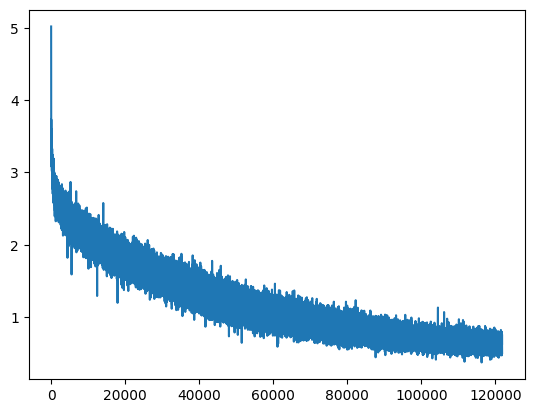

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A male vocalist sings this meditative chant. The tempo is slow with keyboard harmony, steady drumming, 
rhythmic acoustic guitar,tambourine and female vocal backup. The song is a vocal riff of a chant sung melodiously. 
It is calming, peaceful, meditative, pensive, soothing, prayerful and devotional. This song is sung during Hindu 
festivities or Pujas.

TRAIN PRED: The low quality recording features a lullaby sung by soft, passionate female vocals over a mellow, 
arpeggiated acoustic guitar melody. It sounds hypnotic, relaxing, calming and soft. It is in mono, so that is the 
only thing that could make this fall in the low quality category.

TEST TRUE: The low quality recording features a hip hop song that consists of a flat male vocal rapping over punchy
kick and snare hits, shimmering hi hats, DJ scratching sound effects and groovy bass. It sounds energetic, upbeat 
and groovy.

TEST PRED: The low quality recording features a DJ scratching a vinyl of an electro dub song that consists of 
uptempo hi hats, punchy kick and snare hits, short bass stabs, soft crash cymbal and simple synth melody. It sounds
energetic, cool and groovy.

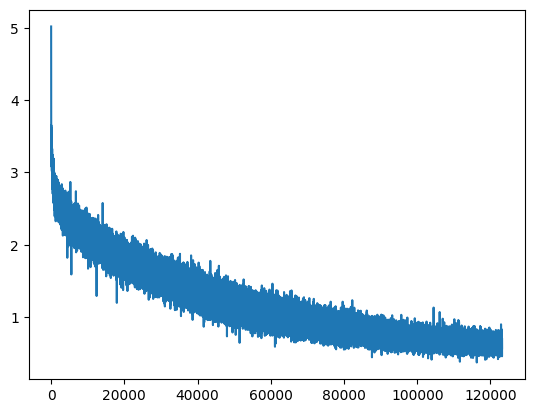

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2087, Train bleu: 0.0917
Valid meteor: 0.2373, Valid bleu: 0.1045
Valid spec-meteor: 0.0355, Valid spec-bleu: 0.0197
Low quality recording count: 75


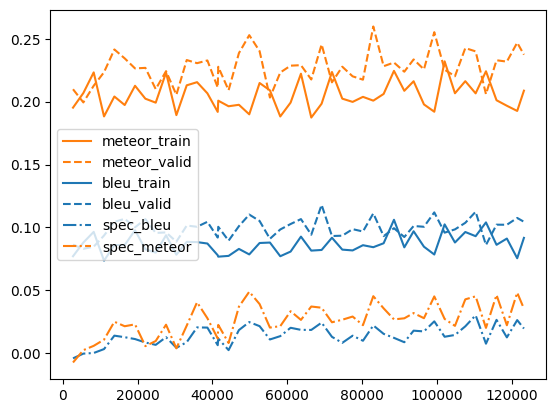

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A folk song is performed live in a low-quality recording with harmonica melodies, groovy double bass 
and shimmering hi-hats. The recording has a wide, noisy quality.

TRAIN PRED: The low quality recording features a live performance of a regional Mexican song that consists of 
reverberant, high register, passionate male vocal singing over acoustic rhythm guitar and widely spread, groovy 
claps. It sounds passionate, traditional and emotional. Judging by the reverb, it was probably played in some huge 
concert hall.

TEST TRUE: The low quality recording features a harmonizing female vocal melody singing over a groovy piano melody.
It sounds happy, joyful and fun, even though the recording is very noisy - to the point that the audio is 
distorted.

TEST PRED: The low quality recording features a live performance of a jazz song that consists of a clarinet solo 
melody played over groovy piano, mellow brass melody, shimmering hi hats and mellow kick hits. It sounds emotional,
easygoing and chill.

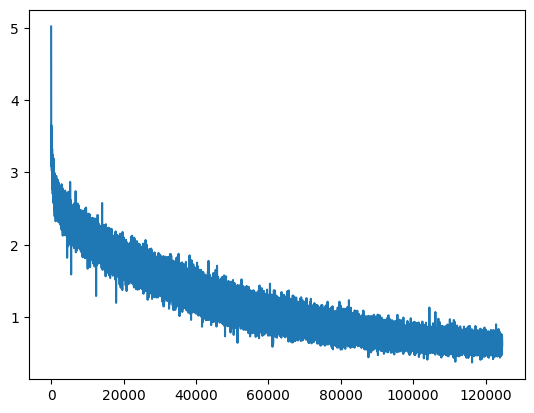

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The cinematic synth in this movie theme piece creates a dramatic ambiance, accompanied by various sound
effects including explosions, thunderstorms, falling objects, and engine sounds. The overall mood is violent and 
suspenseful, making it suitable for sampling and enhancing movie scenes and video game sequences.

TRAIN PRED: The low quality recording features an electro song that consists of a gliding synth lead melody played 
over groovy synth keys chords, exciting synth riser, punchy snare layered with claps, shimmering shakers and punchy
kick hits. It sounds energetic and exciting, due to the fact that it is a build

TEST TRUE: This audio clip features an instruction of playing the guitar. An electric guitar plays a descending 
pentatonic run at two different places on the guitar to give a different feel. The voice narrates the process of 
playing the notes. This is followed by a double stop which is played seven times with a string bend on the eighth 
time. This can be used in an instruction video.

TEST PRED: The low quality recording features a tutorial where a flat male vocalist is talking after a clean 
electric guitar chord is played. Judging by the short snippet at the end of the loop, there is a guitar pedal 
effect that changes the preset of the guitar sound. The recording is noisy and in mono.

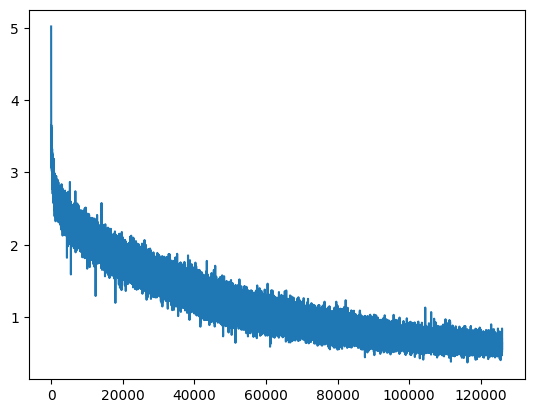

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2269, Train bleu: 0.1028
Valid meteor: 0.2302, Valid bleu: 0.0997
Valid spec-meteor: 0.0360, Valid spec-bleu: 0.0177
Low quality recording count: 74


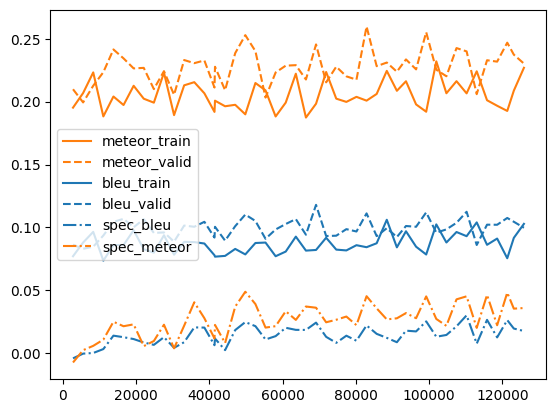

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features an aggressive sound of synth feedback. In the second half of the 
loop, the sound is very noisy. It is loud and it sounds really harsh.

TRAIN PRED: The low quality recording features a drums solo that contains manic tom rolls and a ride cymbal one 
shot at the end. There was an exhale sound once the player finished his performance. The recording is very noisy, 
in mono and it sounds aggressive and energetic.

TEST TRUE: The low quality recording features a quiet bowl resonating sounds and even though the recording is so 
noisy and in mono, it is still calming.

TEST PRED: The low quality recording features a resonating mellow bell playing. It sounds relaxing, calming, soft, 
mellow, haunting and hypnotic. The recording is noisy and in mono.

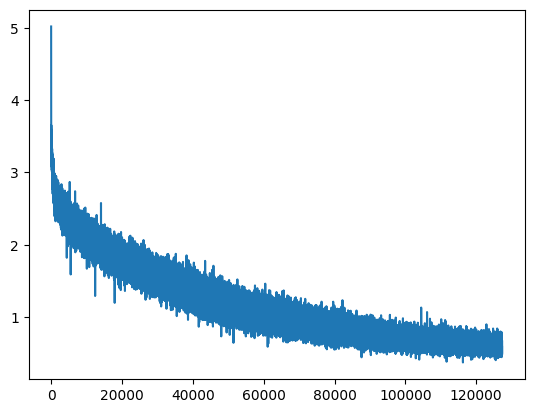

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The composition employs a dual vibraphone performance resulting in a lively atmosphere, enhanced by the
instrument's upbeat quality. The repetitive structure makes it a suitable choice for a ringtone or alarm tone.

TRAIN PRED: The low quality recording features an electro song that consists of a gliding synth lead melody played 
over groovy synth keys chords, exciting synth riser, punchy snare layered with claps, shimmering shakers and punchy
kick hits. It sounds energetic and exciting, due to the fact that it is a build

TEST TRUE: A male vocalist sings this energetic song. The tempo is fast with boomy bass lines, steady drumming, 
keyboard harmony and enthusiastic electric guitar riff with vocal backup. The audio quality is very bad and the 
song is muffled and muddy. This song is a live performance with ambient sounds of people clapping and cheering.

TEST PRED: The low quality recording features a live performance where a DJ is playing his set. There are crowd 
noises in the background. The recording is noisy and it sounds manic, aggressive, distorted and upbeat.

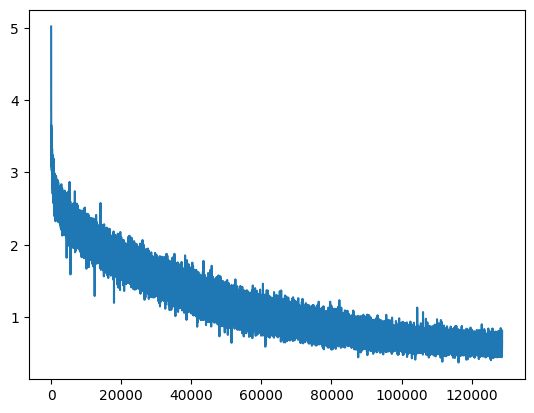

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1949, Train bleu: 0.0857
Valid meteor: 0.2157, Valid bleu: 0.0918
Valid spec-meteor: 0.0115, Valid spec-bleu: 0.0062
Low quality recording count: 65


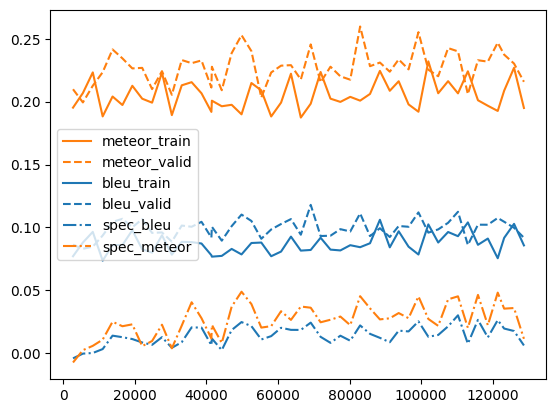

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: Someone is scratching turntables to a backing track coming out of a speaker. This is an amateur 
recording. This song may be playing at home practicing alone.

TRAIN PRED: This clip features a rhythm played on a tambourine. It starts off with a galloping rhythm which is sped
up. At the end, the tambourine is not struck and only the jingles are allowed to ring.  There are no other 
instruments in this song. There are no voices in

TEST TRUE: A female singer sings this passionate melody backed up by singers in vocal harmony. The tempo is slow 
with a strong bass line, steady percussive rhythm and keyboard accompaniment. The song is emotional and spirited. 
The song is a modern hip hop hit.

TEST PRED: A male vocalist sings this mellow song.he tempo is medium with jazz style piano accompaniment, 
synthesiser articulation, slick drumming, funky bass line, cajun beat and an interactive vocal harmony. The music 
is mellow, soothing, ambient, soulful, passionate, emotional and persuasive. This

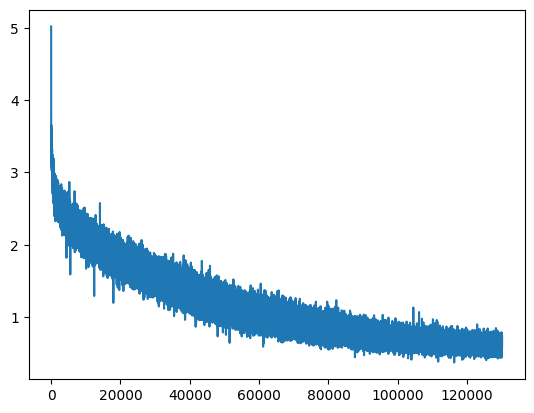

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This jazz song is an instrumental song featuring a trombone playing the main melody. The trombone is 
accompanied by a piano playing chords using jazz rhythms. The tone changes at the end to an uplifting mood. There 
is no percussion in this song. This song can be used in a highway driving scene in a movie.

TRAIN PRED: The low quality recording features a live performance of a jazz song and it consists of a saxophone 
solo melody played over mellow keys chords, groovy bass, punchy snare and kick hits and shimmering hi hats. It 
sounds passionate and soulful.

TEST TRUE: The low quality recording features an uptempo chiptune song playing in the background with some synth 
bells sound effects. In the second half of the loop, there is a loud static noise. The recording is in mono, thin -
as it lacks bass frequencies, crushed - due to the harsh mid range frequencies and it sounds like a video game 
sound.

TEST PRED: The low quality recording features a loud gunshots sound effects, wooden impact and squeaking floor 
sound effects, while a suspicious background music is playing in the background and it consists groovy woodwind 
melody, tinny bells melody located in the left channel of the stereo image and smooth bass. The recording is noisy.

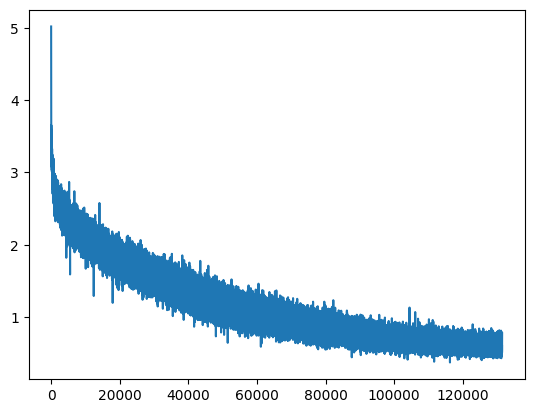

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2092, Train bleu: 0.0909
Valid meteor: 0.2142, Valid bleu: 0.0917
Valid spec-meteor: 0.0275, Valid spec-bleu: 0.0136
Low quality recording count: 84


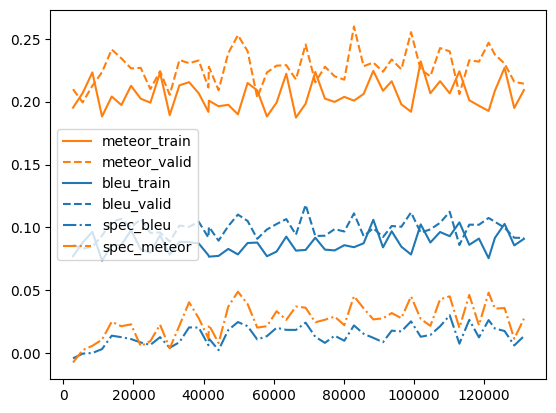

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: At the start, the song showcases a synthesizer lead along with Indian percussion. Meanwhile, in the 
background, a synth choir is playing chords. The synthesizer lead and the other instruments pause, followed by the 
introduction of a techno beat consisting solely of bass and kick. Suitable for a DJ party.

TRAIN PRED: The low quality recording features a lullaby that consists of mellow girl vocal singing over staccato 
string melody in the left channel and plucked strings melody in the right channel of the stereo image. There are 
muffled, barely audible, muffled snare rolls in the background. The recording is noisy and reverberant

TEST TRUE: This audio contains someone playing a fast melody on a harp. This song may be playing as part of a 
video-game.

TEST PRED: The song is an instrumental. The song is medium tempo with a harpsichord belting played with no other 
instrumentation. The music is emotional, passionate and melancholic. The song audio quality is poor.

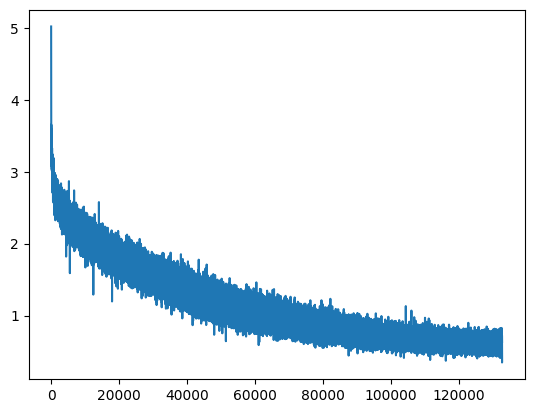

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Checkpoint saved


  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This is a high-octane blues song, with layers of intricate bluesy acoustic guitar playing. There's a 
slide guitar involved, and other layers of potent intense guitar playing. There's a distant filtered vocal hum 
which sounds like it is coming through a telephone.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of flat male vocal
singing over arpeggiated electric guitar melody, groovy bass guitar, shimmering hi hats, snappy rimshots and punchy
kicks. In the background, there are some crowd singing and crowd cheering noises. It sounds

TEST TRUE: This is a soft rock/blues music piece. There is a male vocalist singing melodically in the lead. The 
electric guitar is playing bits and pieces of sound with the slide technique. There is a synth string sound in the 
background. The piece has a story-telling mood to it. The atmosphere is calm. This piece could be playing in the 
background at a coffee shop or a seaside restaurant.

TEST PRED: The low quality recording features a R&B song that consists of echoing harmonizing vocals, alongside 
passionate male vocal singing over noisy percussion, punchy snare and kick hits, pulsating synth melody, synth pad 
chord, shimmering shakers and sizzling triangle. It sounds romantic, passionate and emotional - like something

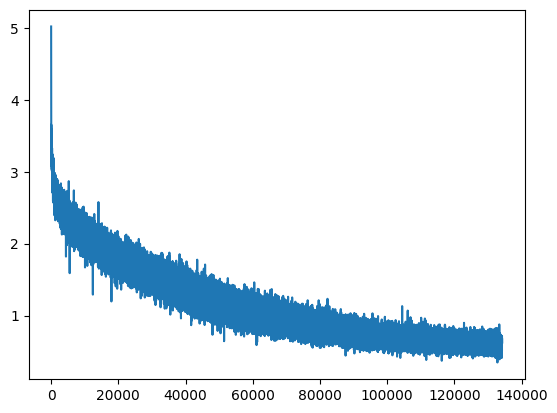

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2122, Train bleu: 0.0964
Valid meteor: 0.2181, Valid bleu: 0.1024
Valid spec-meteor: 0.0317, Valid spec-bleu: 0.0220
Low quality recording count: 66


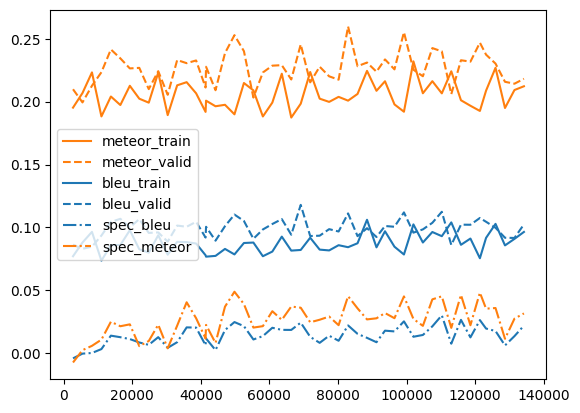

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This is a percussion music piece. There is a medium pitched conga sound providing the rhythm. Clicking 
sounds related to a video game can be heard. Parts of this piece are suitable for a video game.soundtrack.

TRAIN PRED: The low quality recording features a drums solo that contains manic tom rolls and a ride cymbal one 
shot at the end. There was an exhale sound once the player finished his performance. The recording is very noisy, 
in mono and it sounds aggressive and energetic.

TEST TRUE: The low quality recording features a tutorial where a flat male vocal is talking in between harmonica 
tones. The recording is mono and noisy.

TEST PRED: This is the recording of a keyboard lesson. There is a male instructor that plays the notes on the 
keyboard first and then describes the placement of the fingers and the notes that are being played. The audio 
quality of the lesson is not that great.

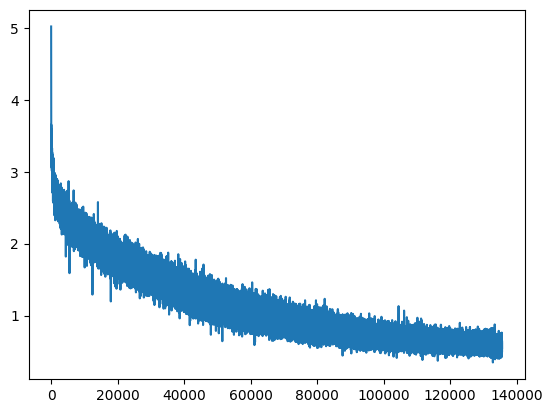

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A male Latin singer sings this cool melody. The song is medium tempo with keyboard accompaniment and 
steady drumming rhythm and a percussive bass-line with missing harmonies. The song is experimental and has bad 
audio quality.

TRAIN PRED: The low quality recording features a hip hop song that consists doubled, cool male vocals, alongside 
background male ad libs, rapping over jazzy piano chords, groovy kick, shimmering hi hats and soft snare hits all 
located in the right channel of the stereo image, making it unbalanced. The recording

TEST TRUE: This music is a sinister Electronic instrumental. The tempo is medium with a claviharp melody and 
keyboard accompaniment with digital sounds and a menacing roar and grunt. The music is intense, sinister, scary, 
anticipating danger, menacing, mysterious and suspenseful.

TEST PRED: The low quality recording features a classical song that consists of a mellow french horn melody playing
over wide strings. It is a bit noisy and it sounds passionate, easygoing and like something you would hear as a 
background music for old movies.

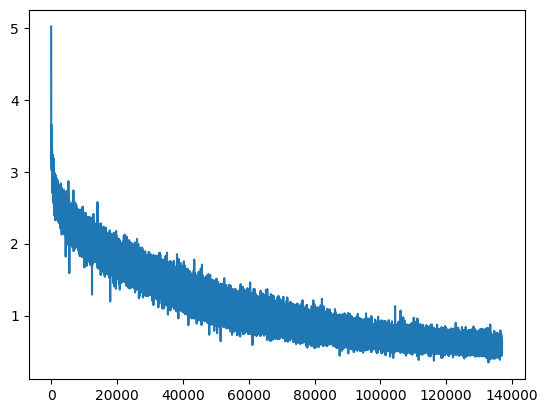

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2377, Train bleu: 0.1210
Valid meteor: 0.2394, Valid bleu: 0.1070
Valid spec-meteor: 0.0451, Valid spec-bleu: 0.0265
Low quality recording count: 68


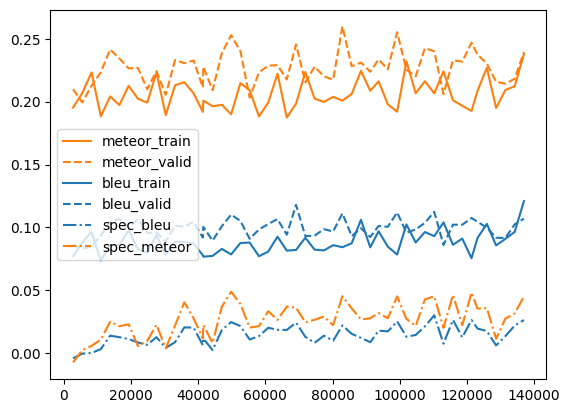

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A low fidelity recording of a drone instrument playing a chord while a female singer and double reed 
instrument double a technically challenging melody.

TRAIN PRED: The low quality recording features a traditional song that consists of passionate female vocal singing 
over wooden percussive elements, strings and flute melody. It sounds passionate, emotional and soulful and the 
recording is noisy and in mono.

TEST TRUE: This is a Carnatic classical music piece. It is a live performance. There is a male vocalist singing in 
a versatile manner. The melody is being played by the Carnatic violin. There is a tabla percussion beat in the 
rhythmic background. There is a complex feel to the piece. The atmosphere is vibrant.

TEST PRED: The low quality recording features a drum solo that consists of punchy snare hits and occasional snare 
roll, punchy kick and shimmering hi-hats. It sounds energetic and the recording is noisy.

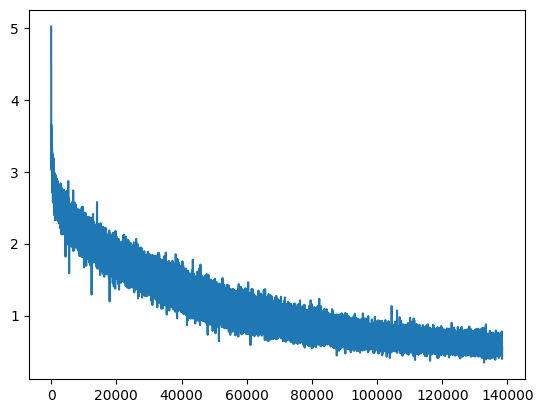

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A gospel song is performed live and recorded in low quality. The choir vocals blend in harmony in a 
spacious environment, evoking sentiments of passion, emotion, soulfulness, and strength.

TRAIN PRED: The low quality recording features fruity male vocals, alongside background crowd noise, talking, after
which a trap song, that consists of passionate male vocal and addictive synth brass lead melody, starts playing. It
sounds exciting and passionate.

TEST TRUE: An acoustic guitar is strumming chords. A violin is playing a melody along with a flue and another 
hammered string instrument. Percussions are being played in a rhythm that is not a 4 bar count. All the instruments
are spread across the sides of the speakers. This song may be playing in a desert movie scene.

TEST PRED: The low quality recording features a live performance of a jazz song that consists of a clarinet solo 
melody played over groovy piano, mellow brass melody, shimmering hi hats and mellow kick hits. It sounds emotional,
easygoing and chill.

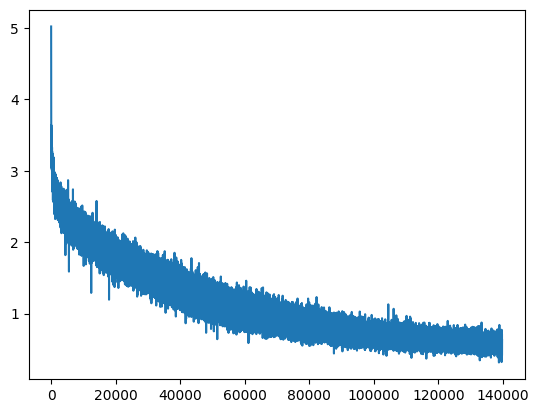

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2465, Train bleu: 0.1170
Valid meteor: 0.2278, Valid bleu: 0.0993
Valid spec-meteor: 0.0280, Valid spec-bleu: 0.0141
Low quality recording count: 68


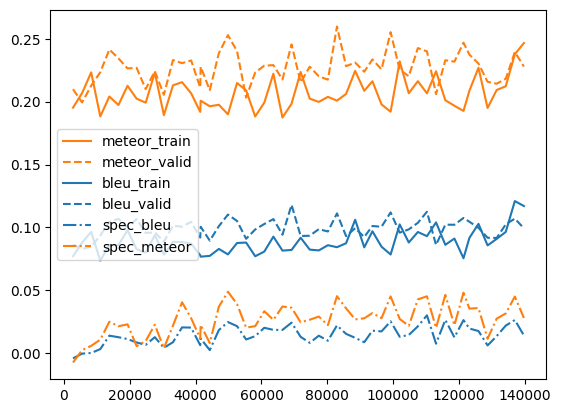

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This song features male voices singing in harmony. It starts off on a high note, followed by a lower 
note and back up to a high note. At the end, a vocoder is used to give a start-stop effect to the voice. The ending
of the voice is like if a person were to drive over road ramblers. There is a lot of reverb added to the voice.

TRAIN PRED: The low quality recording features a live performance of a traditional song and it consists of a flat 
male vocal singing over sustained strings melody and mellow, subtle percussive element. There are some people 
talking in the background, followed by a cough. It sounds passionate and emotional, even though the recording is 
noisy and in

TEST TRUE: The low quality recording features a wide arpeggiated electric guitar melody. It sounds clean, 
passionate and the recording is a bit noisy.

TEST PRED: The low quality recording features a pop song that consists of mellow female vocals, followed by female 
background vocals, singing over punchy kicks, claps, shimmering open hats, stuttering hi hats, buzzy synth bass and
wide synth pad chords. It sounds aggressive, bright, punchy, energetic and kind of

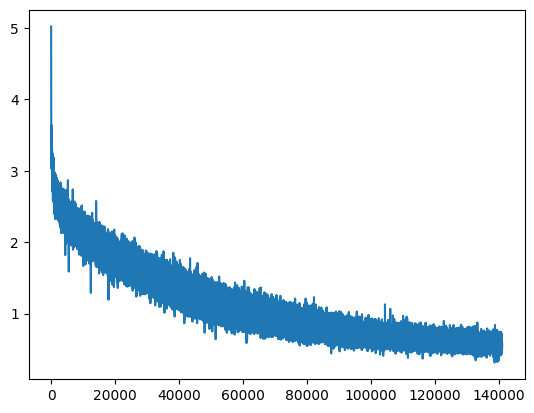

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A traditional song is featured in the recording, with a male vocal singing passionately and accompanied
by a breathy flute melody, tambourine, claps, wooden percussion, and strings. The overall sound is emotional and 
intense, though the quality of the recording is low.

TRAIN PRED: The low quality recording features a rock song that consists of throaty male vocal singing over widely 
spread arpeggiated electric guitar melody, smooth bass guitar, punchy snare, shimmering hi hats and soft kick hits.
It sounds thin, distorted and messy, since the frequencies are clashing.

TEST TRUE: The low quality recording features a digital piano, funky chords played over punchy kick, fat snare and 
shimmering hi hats. The digital piano uses a wah pedal effect, which makes it sound funky and groovy.

TEST PRED: The song is an instrumental. The song is medium tempo with various Latin percussion playing groovily to 
the sounds of a Rhodes organ melody. The song is romantic and passionate. The soundtrack is a demonstration for a  
keyboard model.

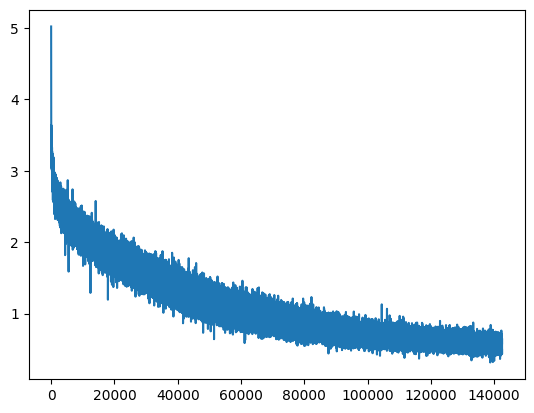

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2091, Train bleu: 0.0901
Valid meteor: 0.2028, Valid bleu: 0.0820
Valid spec-meteor: 0.0169, Valid spec-bleu: 0.0069
Low quality recording count: 67


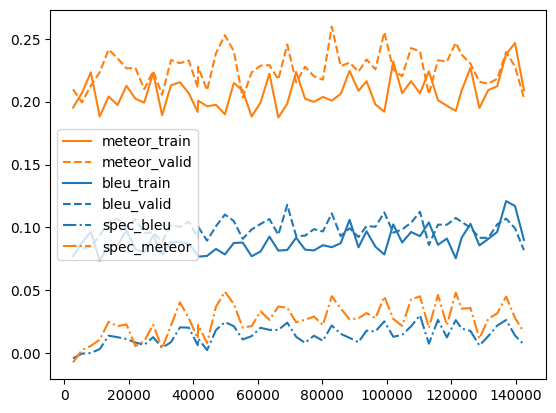

In [ ]:
for epoch in tqdm(range(epoch, num_epochs)):
    wlog(f"\nEpoch {epoch}")

    torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
    }, checkpoint_dir / f"chkp_{string_info}.pt")
    #}, checkpoint_dir / f"chkp_{epoch}.pt")
    
    if epoch>500 and epoch % 100 == 0:
        print("Checkpoint saved")
        wlog("Checkpoint saved")
        torch.save({
            "model": model.state_dict(), 
            "b2t": b2t.state_dict(), 
            "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}_e{epoch}.pt")

    if epoch == gpt2_finetune_start_epoch:
        print("Started finetuning b2t")
        wlog("Started finetuning b2t")
        torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}.pt")
        opt.param_groups[0]["lr"] = b2t_lr
        for pg in opt.param_groups[1:]:
            pg["lr"] = gpt2_finetune_lr

    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(list(caption_batch))
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch, input_ids, input_ids_target
        )

        apply_grad_cond = step % gradient_acc_fact == 0
        losses.append(
            update_step(inputs_embeds, input_ids_target, apply_grad=apply_grad_cond)
        )

        if epoch % 10 == 0 and step % 500 == 0:
            wlog(f"Loss {np.mean(losses[-500:])}\n")
            eval_step(string_info=string_info)
                
            plt.plot(losses, label='train_loss')
            plt.savefig(f"plots/plot_loss_{string_info}.png")
            plt.show()
            plt.clf()
            
            if epoch % 20 == 0 and epoch>0:
                
                metrics_results = metrics_step(n=100)
                metrics['step'].append(len(losses))
                for m in ['meteor_train', 'meteor_valid', 'bleu_train', 'bleu_valid', 'spec_bleu', 'spec_meteor']:
                    metrics[m].append(metrics_results[m])
                    plt.plot(metrics['step'], metrics[m], label=m, linestyle=m_styles[m][1], color=m_styles[m][0])
                plt.legend()
                plt.savefig(f"plots/plot_metrics_{string_info}.png")
                plt.show()

                with open(f'outputs/train_metrics_{string_info}.npy', 'wb') as f:
                    metrics_to_save = {k: np.array(a) for k, a in metrics.items()}
                    metrics_to_save['loss'] = np.array(losses)
                    np.save(f, metrics_to_save)

# Generate eval captions

In [ ]:
import evaluate

meteor = evaluate.load('meteor')
google_bleu = evaluate.load('google_bleu')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
for ep in tqdm(["260", "270", "275", "280"]):
    
    eval_true_captions = []
    eval_pred_captions = []
    # load epoch checkpoint
    model_path = f"checkpoints/chkp_no_0.0001_0_0.0001_e{ep}.pt"
    data_dict = torch.load(model_path)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

    # generate a bunch of captions with this checkpoint
    # for some reason hf generate() breaks atm when using batched captions, idk why
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(eval_test_dataloader)):
        pred = eval(list(caption_batch), embedding_batch, **generation_params)
        eval_true_captions.append(caption_batch[0])
        eval_pred_captions.append(pred[0])
        if i >= 1000:
            break

    gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
    meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
    print(ep, gleu_score, meteor_score)
    
    eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

    shuffled_gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
    shuffled_meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    print(ep, gleu_score-shuffled_gleu_score, meteor_score-shuffled_meteor_score)

In [ ]:
ls checkpoints

In [40]:
eval_true_captions = []
eval_pred_captions = []

model_path = "checkpoints/chkp_no_0.0001_0_0.0001_chataug_e900.pt"
data_dict = torch.load(model_path)
model.load_state_dict(data_dict['model'])
b2t.load_state_dict(data_dict['b2t'])

eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

for i, (caption_batch, embedding_batch) in tqdm(enumerate(eval_test_dataloader)):
    pred = eval(list(caption_batch), embedding_batch, **generation_params)
    eval_true_captions.append(caption_batch[0])
    eval_pred_captions.append(pred[0])
    
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions,
    tracks_ids = sorted(test_ytids)
), open('outputs/preds_gpt2_notag_chataug.json', 'w'))

0it [00:00, ?it/s]

In [41]:
gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
print(gleu_score, meteor_score)

eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

shuffled_gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
shuffled_meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
print(gleu_score-shuffled_gleu_score, meteor_score-shuffled_meteor_score)

0.09300621039689795 0.220900604953171
0.014182149871975011 0.030469027004296517


In [38]:
eval_true_captions = []
eval_pred_captions = []

model_path = "saved-models/best-notag-noaug.pt"
data_dict = torch.load(model_path)
model.load_state_dict(data_dict['model'])
b2t.load_state_dict(data_dict['b2t'])

eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

for i, (caption_batch, embedding_batch) in tqdm(enumerate(eval_test_dataloader)):
    pred = eval(list(caption_batch), embedding_batch, **generation_params)
    eval_true_captions.append(caption_batch[0])
    eval_pred_captions.append(pred[0])

0it [00:00, ?it/s]

In [39]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions,
    tracks_ids = ["-"+str(x) for x in sorted(test_ytids)]
), open('outputs/preds_gpt2_notag_noaug.json', 'w'))

In [ ]:
gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']

gleu_score, meteor_score

In [ ]:
eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    
gleu_score, meteor_score

In [ ]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions
), open('preds.json', 'w'))